In [1]:
#############################################
#BASIC PACKAGES
import sys,time,os
from copy import deepcopy as dcopy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#############################################
#PATH TO SCRIPTS FOLDER
path = '/data/AMARINS/CMBWLxHI-CODES/scripts/'
sys.path.insert(1, path)
import cross_functions_theory      as cxft
#import cross_functions_simulations as cxfs
# it's required healpy  (https://healpy.readthedocs.io/en/latest/index.html)
import healpy        as hp
import handling_data as hdata
import noise_functions as fnoise
import pandas as pd

#############################################
## MATPLOTLIB FEATURES
from matplotlib import cm
font = {'weight' : 'bold','size'   : 22}
mpl.rc('font', **font)
mpl.rc('font',   size=209)  #set defaults so that the plots are readable
mpl.rc('axes',   titlesize=20)
mpl.rc('axes',   labelsize=20)
mpl.rc('xtick',  labelsize=20)
mpl.rc('ytick',  labelsize=20)
mpl.rc('legend', fontsize =20)
mpl.rc('figure', titlesize=20)
mpl.rc('text',   usetex=True)
## FURTHER MATPLOTLIB FEATURES
from matplotlib.lines import Line2D
#from matplotlib.patches import Patch
#from matplotlib.markers import MarkerStyle
#from matplotlib.transforms import Affine2D
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
colors = ['darkgrey', '#0000ff', '#ff0000', '#0000FF',  '#FF0000', '#069AF3', '#00008B','#C79FEF','#DC143C','#C875C4','#9A0EEA','darkorange','#C79FEF','#7E1E9C','silver','#FF7F50','#FC5A50',
          '#FFA500','#F97306','#FFD700','#DDA0DD','#00008B','#069AF3','#0000FF','#00FFFF','#13EAC9','#7FFFD4','#04D8B2','#40E0D0']
my_cmap = ListedColormap(colors, name="my_cmap")#mpl.cm.Dark2#.reversed()#
#my_cmap_r = my_cmap.reversed()
font_dict = {'family': 'serif', 'color':  None,  'weight': 'bold','size': 30}
#############################################
sys.path.insert(1, '/data/AMARINS/BEAM_ANALYZES/beam_analyzes-main')    
import beam_modelling         as model
#############################################
## NAMASTER (https://namaster.readthedocs.io/en/latest/)
import pymaster as nmt
del_l  = 20
nside  = 256
##############################
b    = nmt.NmtBin.from_nside_linear(nside, nlb=del_l)
leff = b.get_effective_ells()
feff = leff*(leff+1)/2/np.pi

# HIGH-Z

c = 3e8  #speed of light
D = 13.5 #dish diameter
nch_highz = 70
fwhm_max = np.degrees(1.22*c/D/(350*1e6))
fwhm_min = np.degrees(1.22*c/D/(1050*1e6))
#(fwhm_max + fwhm_min)/2

In [2]:
nu_vec_lowz = hdata.nu_bins_vector(numin_ =980, numax_ =1260, nbands_=30)['nu']
nuvec_lowz_eff = np.array([ 0.5*(nu_vec_lowz[i]+nu_vec_lowz[i+1]) for i in range(nu_vec_lowz.size-1) ])

In [3]:
output_info = {'field':'WN', 
               "frequency":{"min":350,"max":1050,'nbands':70},
               "coverage":'full',
               "apply_beam":False,               
               'beam': {'model':None, 'fwhm':0}, 
               'stokes':None,
               "freq_unit":"MHz", "stokes_unit":"mk", "fwhm_unit":"arcmin",
               'nside':256,
               "realization":1,
               "output_dir":'/data/AMARINS/MAPS/WN256',
               "clear_output_dir":False,
               "apply_mask":False,
               "pathmask":'/data/AMARINS/`MAPS/M256',
               "savedata_hdu" : 1}

In [4]:
nu_vec_highz = hdata.nu_bins_vector(numin_ =output_info['frequency']['min'], 
                                    numax_ =output_info['frequency']['max'], 
                                   nbands_=output_info['frequency']['nbands'])['nu']
nuvec_highz_eff = np.array([ 0.5*(nu_vec_highz[i]+nu_vec_highz[i+1]) for i in range(nu_vec_highz.size-1) ])

In [5]:
for jch in range(nuvec_highz_eff.size):
    sigma_info = {'nside' :output_info['nside'],
                  'nbeams':425,#int(197*(64800/30000))
                  'Osur'  :64800,#5324,
                  'Obeam' :np.pi*(2/2)**2, #pi*(FWHM/2)^2
                  'tsur'  :1,
                  'K'     :1,#2**(1/2),
                  'fsky'  :1,#0.13,
                  'dcycle':1,
                  'output_unit':'mK'}#0.9}    
    sigma_info['nch']   =70
    sigma_info['nu_min']=nu_vec_highz[jch]
    sigma_info['nu_max']=nu_vec_highz[jch+1]
    sigma_info['nu_eff']=nuvec_highz_eff[jch] 
    sigma_info['Tsys']=fnoise.Tsys_SKA_MID_band1(nuvec_highz_eff[jch])#K
    gnoise = hdata.get_noise_level(sigma_info)
    jwn = np.random.normal(scale = gnoise['sigmaN'], size=(1,12*sigma_info['nside']**2))
    cl_jwn = hp.anafast(jwn,pol=False)
    WN_highz = jwn if not jch else np.vstack(( WN_highz,jwn ))
    Cl_wn_highz  = cl_jwn if not jch else np.vstack(( Cl_wn_highz,cl_jwn ))
    del jwn, cl_jwn    

In [6]:
for w in WN_highz:
    pass
    #print(np.std(w))

In [7]:
gnoise['sigma_pix']

0.0827868162777849

In [8]:
###########################################################################################
### LOW-Z 
dirpath  = "/data/AMARINS/MAPS/WN256"
filename = "WN_None_256_980mhz1260mhz_30bins_full_L0001.fits"
WN_lowz = hdata.getmap(dirpath_=dirpath, filename_=filename, healpix_readingformat=False, hdu=1)
for j, jwn in enumerate(WN_lowz):
    Cl_wn_lowz = hp.anafast(jwn,pol=False) if not j else  np.vstack(( Cl_wn_lowz, hp.anafast(jwn,pol=False) ))
###########################################################################################
### HIGH-Z 
#Cl_wn_highz
#WN_highz
###########################################################################################
### CMB CONVERGENCE (CMB-S4)
path_cmbk = '/home/amarins/fullsky.xlsx'
Ncmbk_tab = pd.read_excel(path_cmbk, index_col=None, header=None) #[l, ((l(l+1))^2/2pi)Cl ]
Nkcmb = np.hstack((Ncmbk_tab[1].values[0],Ncmbk_tab[1].values[0],Ncmbk_tab[1].values))
lcmb = np.arange(Nkcmb.size)
###########################################################################################
### GAL CONVERGENCE (LSST)
nu_min = 24
nu_max = 29
bins   = np.arange(nu_min,nu_max+1)
sigma_eps_2 = 0.26
Nbins = bins.size 
ngal  = 27        #gal/arcmin2
Apix  = 5.49      #arcmin2
sigma2   = sigma_eps_2/(ngal/Apix/Nbins) #standard deviation ~ N(0,sgm)
WN_kappa = np.random.normal(scale = np.sqrt(sigma2), size=(Nbins,12*nside**2))
Nkgal    = np.zeros_like(Cl_wn_lowz)
kch=0
for jch in range(WN_lowz.shape[0]):
    if jch in bins:
        Nkgal[jch] = hp.anafast(WN_kappa[kch], pol=False)
        kch+=1
l=np.arange(Cl_wn_lowz[0].size)

In [19]:
np.average(WN_kappa)*1000

-0.1909835444792211

'/data/AMARINS/CMBWLxHI-CODES/images/noises.png'

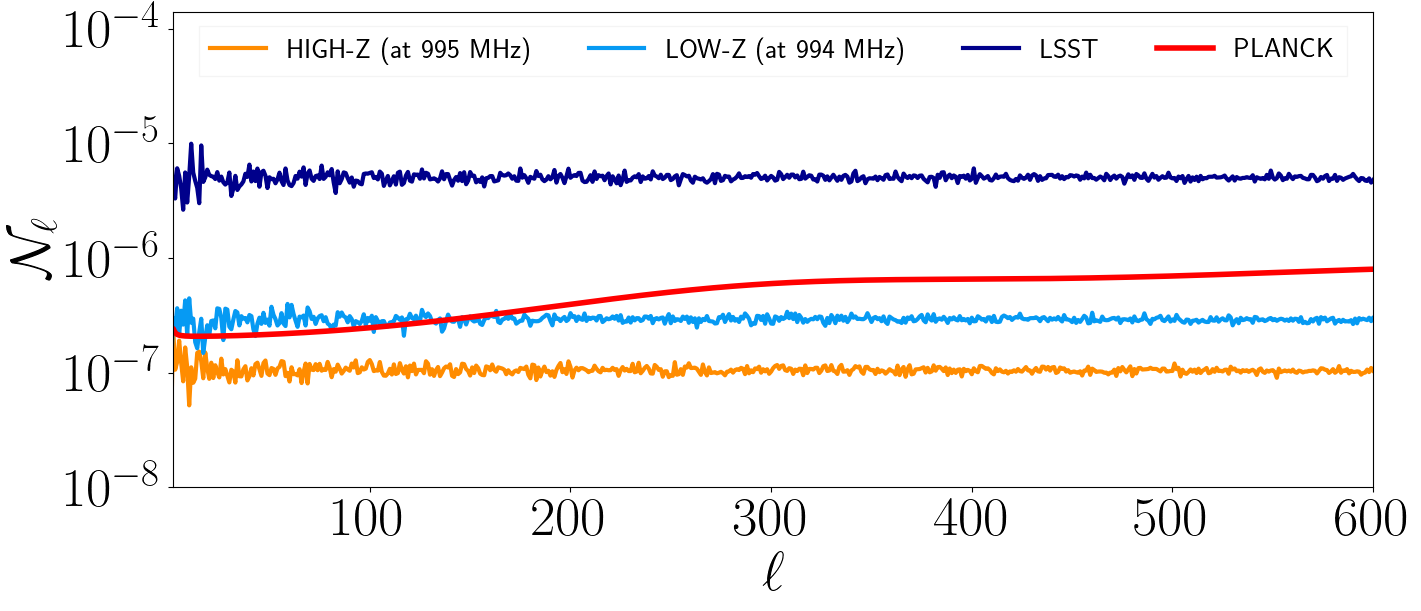

In [9]:
fig   = plt.figure()
grid  = plt.GridSpec(1,1,top=1.1,right=2,hspace=0)
############################################################
savefigs=True
cyticks = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4]
cxticks = [100,200,300,400,500,600]
jch_low  = 1
jch_high = 64
###########################################################
ax  = plt.subplot(grid[0,0])
ax.plot(   l, Cl_wn_highz[jch_high], c=my_cmap(11), lw=3, label='HIGH-Z (at {:.0f} MHz)'.format(nuvec_highz_eff[jch_high]))
ax.plot(   l, Cl_wn_lowz[jch_low]  , c=my_cmap(5 ), lw=3, label='LOW-Z  (at {:.0f} MHz)'.format(nuvec_lowz_eff[jch_low]  ))
ax.plot(   l, Nkgal[24]       , c=my_cmap(6 ), lw=3, label='LSST'         )
ax.plot(lcmb, Nkcmb                , c=my_cmap(2 ), lw=4, label='PLANCK'       )
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_yscale('log'); ax.set_xscale('linear')
ax.set_xlim(2,600)
ax.set_ylim(1e-8,1.4e-4)
ax.set_yticks(cyticks)
ax.set_xticks(cxticks)
ax.set_ylabel(r'$\mathcal{N}_{\ell}$', fontsize=40)#($\kappa, \textrm{HI}$)')
ax.set_xlabel(r'$\ell$', fontsize=40)#($\kappa, \textrm{HI}$)')
ax.tick_params(axis='both', labelsize=40)
ax.legend( fontsize=20, loc='upper center', ncols=4 ,framealpha=0.2, fancybox=False)
#######################################
###########################################################
pathname = '/data/AMARINS/CMBWLxHI-CODES/images/noises.png'
#if savefigs: plt.savefig(pathname, dpi=100, bbox_inches='tight')
pathname

In [44]:
print(cxft.get_zeff(numin =980,numax =1260,nbands=30,n_curves=30)['zeff'][jch_low])
print(cxft.get_zeff(numin =350,numax =1050,nbands=70,n_curves=70)['zeff'][jch_high])

0.43
0.43


# BEAMS

def bl_function(fwhm=None, lmax=None, theta_=None, input_unit="radian", from_real_space=False): 
    if input_unit=="radian":
        pass
    elif input_unit=="degree":
        fwhm = np.radians(fwhm)
        try:
            theta_ = np.radians(theta_)
        except:
            pass
    elif input_unit=="arcmin":
        fwhm = np.radians(fwhm/60)
        try:
            theta_ = np.radians(theta_/60)
        except:
            pass
    else:
        pass   
    if from_real_space:
        bl  = model.beam_function(type_,fwhm=fwhm, theta_=theta_)
        bl = hp.beam2bl(bl,theta_,lmax)    
        bl = bl/bl.max()
    else:
        if type(lmax)==type(None):lmax=768
        l  = np.arange(lmax+1)
        bl = np.exp(-0.5*l*(l+1)*fwhm**2/8/np.sqrt(2))
    return bl

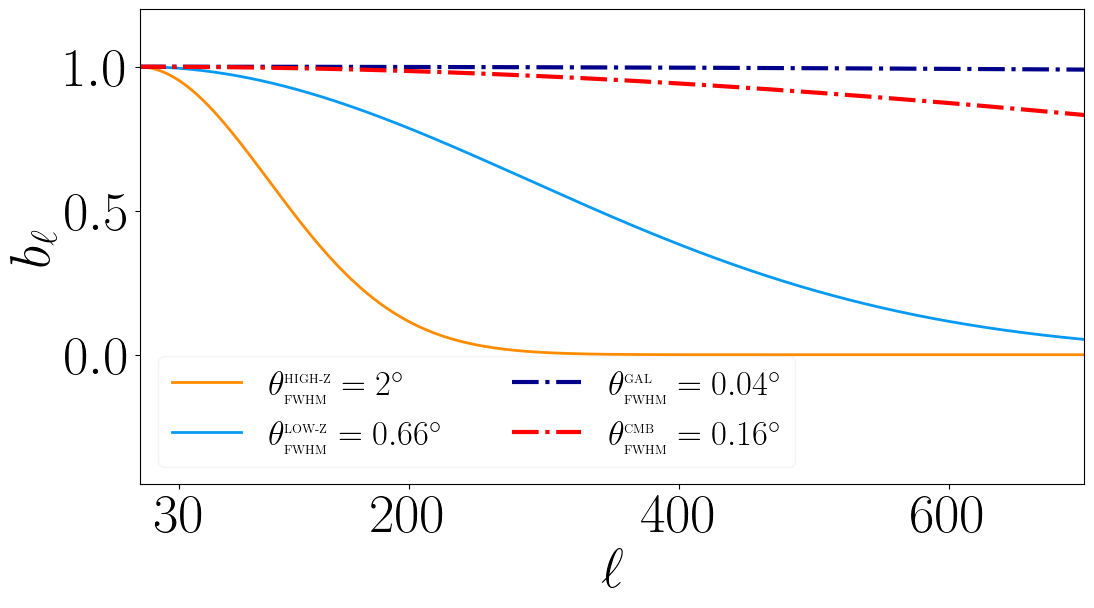

In [40]:
fig   = plt.figure()
grid  = plt.GridSpec(1,1,top=1.1,right=1.6,hspace=0)
############################################################
ax  = plt.subplot(grid[0,0])
blg_th_lowz  = fnoise.bl_function(40/60, input_unit="degree", from_real_space=False)[:-1]
blg_th_highz = fnoise.bl_function(2    , input_unit="degree", from_real_space=False)[:-1]
blg_ck       = fnoise.bl_function(10/60, input_unit="degree", from_real_space=False)[:-1]
blg_gk       = fnoise.bl_function(np.sqrt(5.49)/60, input_unit="degree", from_real_space=False)[:-1]
###
ax.plot(blg_th_highz, ls='-' ,lw=2, c=my_cmap(11), label=r'$\theta^{\small\textrm{HIGH-Z}}_{\small\textrm{FWHM}} = 2^{\circ}$')
ax.plot(blg_th_lowz , ls='-' ,lw=2, c=my_cmap(5), label=r'$\theta^{\small\textrm{LOW-Z}}_{\small\textrm{FWHM}} = 0.66^{\circ}$')
ax.plot(blg_gk      , ls='-.',lw=3, c=my_cmap(6), label=r'$\theta^{\small\textrm{GAL}}_{\small\textrm{FWHM}} = 0.04^{\circ}$')
ax.plot(blg_ck      , ls='-.',lw=3, c=my_cmap(2), label=r'$\theta^{\small\textrm{CMB}}_{\small\textrm{FWHM}} = 0.16^{\circ}$')
###
ax.set_ylabel(r'$b_{\ell}$', fontsize=40)
ax.set_xlabel(r'$\ell$', fontsize=40)
ax.tick_params(axis='both', labelsize=40)
ax.set_xlim(1,700)
ax.set_xticks([30,200,400, 600])
ax.set_ylim(-0.45,1.2)
###
ax.legend(ncols=2, framealpha=0.2,fontsize=25, loc='lower left')

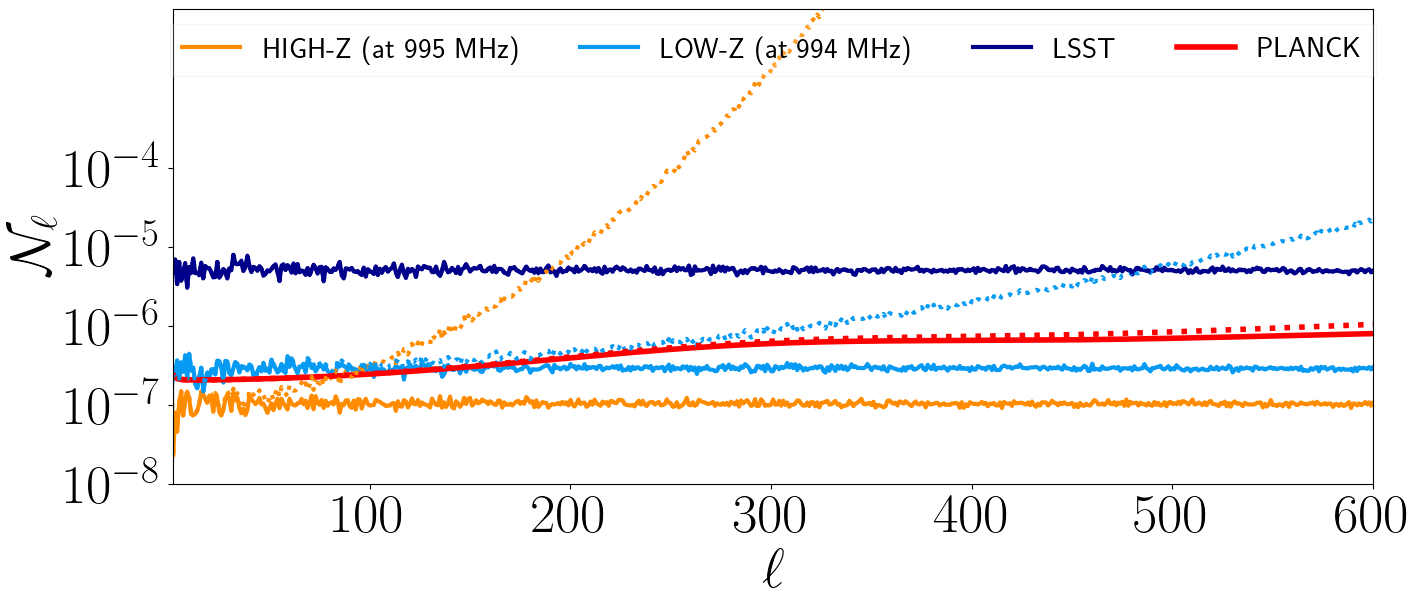

In [41]:
fig   = plt.figure()
grid  = plt.GridSpec(1,1,top=1.1,right=2,hspace=0)
############################################################
savefigs=True
cyticks = [ 1e-8,1e-7, 1e-6, 1e-5, 1e-4]
cxticks = [100,200,300,400,500,600]
jch_low  = 1#24
jch_high = 64
###########################################################
ax  = plt.subplot(grid[0,0])
ax.plot(   l, Cl_wn_highz[jch_high], c=my_cmap(11), lw=3, label='HIGH-Z (at {:.0f} MHz)'.format(nuvec_highz_eff[jch_high]))
ax.plot(   l, Cl_wn_lowz[jch_low]  , c=my_cmap(5 ), lw=3, label='LOW-Z  (at {:.0f} MHz)'.format(nuvec_lowz_eff[jch_low]  ))
ax.plot(   l, Nkgal[24]       , c=my_cmap(6 ), lw=3, label='LSST'         )
ax.plot(lcmb, Nkcmb                , c=my_cmap(2 ), lw=4, label='PLANCK'       )

ax.plot(   l, Cl_wn_highz[jch_high]/(blg_th_highz**2), ls=':', c=my_cmap(11), lw=3, )
ax.plot(   l, Cl_wn_lowz[jch_low]/(blg_th_lowz**2)   , ls=':',c=my_cmap(5 ), lw=3, )
ax.plot(   l, Nkgal[24]/(blg_gk**2)             , ls=':',c=my_cmap(6 ), lw=3, )
ax.plot(lcmb[:768], Nkcmb[:768]/(blg_ck**2)          , ls=':',c=my_cmap(2 ), lw=4, )


ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_yscale('log'); ax.set_xscale('linear')
ax.set_xlim(2,600)
ax.set_ylim(1e-7,1e-2)
ax.set_yticks(cyticks)
ax.set_xticks(cxticks)
ax.set_ylabel(r'$\mathcal{N}_{\ell}$', fontsize=40)#($\kappa, \textrm{HI}$)')
ax.set_xlabel(r'$\ell$', fontsize=40)#($\kappa, \textrm{HI}$)')
ax.tick_params(axis='both', labelsize=40)
ax.legend( fontsize=21, loc='upper center', ncols=4 ,framealpha=0.2, fancybox=False)
#######################################

NameError: name 'leq' is not defined

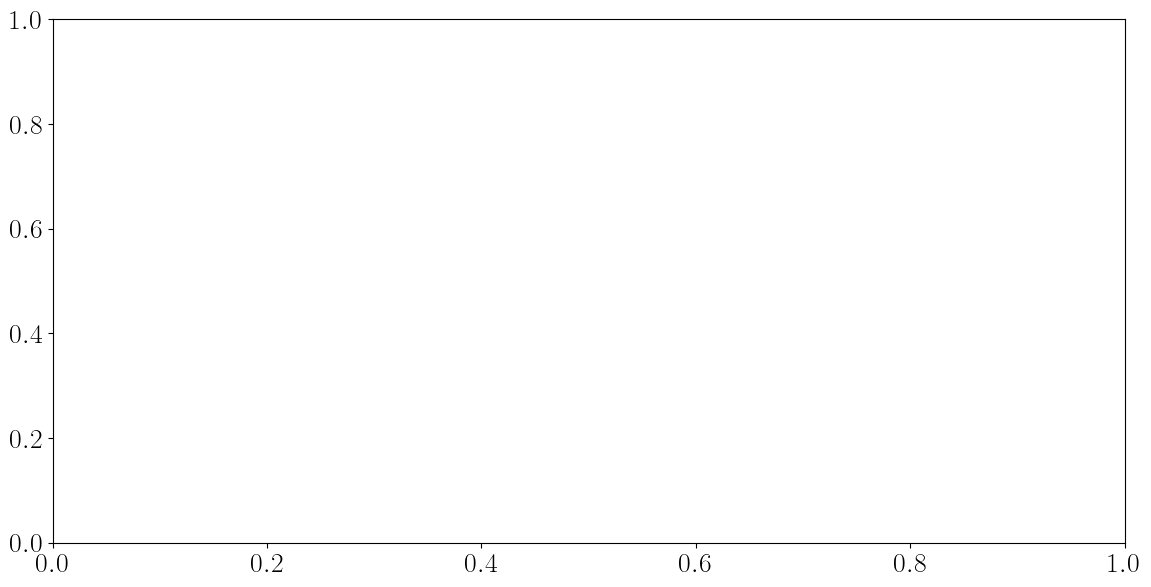

In [42]:
fig   = plt.figure()
grid  = plt.GridSpec(1,1,top=1.2,right=1.8,hspace=0)
i=25;ax  = plt.subplot(grid[:2,0])
############################################################
ax.plot(leq, Cl_wn_high[65], c='royalblue' , lw=2.5, label='HI high-z'.format(i+1))
ax.plot(leq, Cl_wn[i]      , c='teal'      , lw=2.5, label='HI low-z'.format(i+1))
ax.plot(leq, Nkgal[i]      , c='firebrick' , lw=2  , label='LSST-like')
ax.plot(leq, Nkcmb         , c='darkviolet', lw=2  , label='CMB-S4-like')

ax.plot(leq, Cl_wn_high[65]/(blg_hi_highz**2), c='royalblue' , lw=1.5, ls='dashed')
ax.plot(leq, Cl_wn[i]/(blg_hi**2)            , c='teal'      , lw=1.5, ls='dashed')
ax.plot(leq, Nkgal[i]/(blg_kgal**2)          , c='firebrick' , lw=1.5, ls='dashed')
ax.plot(leq, Nkcmb/(blg_kcmb**2)             , c='darkviolet', lw=1.5, ls='dashed')

ax.axvline(x=150, ls='dotted', color='black')
ax.axvline(x=50, ls='dotted', color='black')

ax.set_xlim(2,600)
ax.set_ylim(1e-9,1e-2)
ax.set_ylabel(r'$\mathcal{N}_{\ell}$', fontsize=40)#($\kappa, \textrm{HI}$)')
ax.set_xlabel(r'$\ell$', fontsize=40)#($\kappa, \textrm{HI}$)')
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.tick_params(axis='both', labelsize=40)
ax.set_yscale('log'); ax.set_xscale('linear')
ax.legend( fontsize=20, loc='upper center', ncols=4,framealpha=0.4)
#######################################
plt.tight_layout()